<a href="https://colab.research.google.com/github/owengenge/cap-comp215/blob/main/Sugarscape_Notebook_Owen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sugarscape**
---
The purpose of this notebook is to explain the concept of Sugarscape through documentation, computational techniques, and expirements.

The code used is based on code from ch. 11 Agent-Based Models in Think Complexity, 2nd edition. Copyright 2016 Allen Downey, MIT License as well as code by Joseph Fall (Animation2D class, plot_2D_array function, code from sugarscape.ipynb notebook)


Name: Owen Genge

Date: April 10, 2023 

## **Setup**

Includes import libraries, plot_2D_array function, Animation2D class.

Feel free to minimize this

Import Libraries

In [20]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

!pip install empiricaldist

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import chain

import time

from Cell2D import Cell2D, draw_array
from utils import decorate, three_frame
from empiricaldist import Cdf

import pprint
import matplotlib
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


plot_2D_array Function 

In [21]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

Animation2D Class

In [22]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## **What is Sugarscape?**

**Sugarscape** is a simple agent based computational model developed by Joshua Epstein and Robert Axtell in 1996. 

It simulates an artificial society where agents move and interact on a grid, collecting and consuming a limited resource called "sugar". Agents have different attributes such as vision, metabolism, and lifespan, which affect their behavior and survival. 

Sugarscape is often used as a model for studying complex systems, emergence of social behaviors, and exploring the dynamics of resource distribution and consumption in a spatially explicit environment.

## **Useful Functions**

In [23]:
def make_locs(n, m):
    """ Return list of (x, y) coordinates for all locations on n x m grid """
    return [(i, j) for i in range(n) for j in range(m)]

def distances_from(n, i, j):
    """Computes an array of distances.
    n: size of the array
    i, j: coordinates to find distance from
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

print(f'make_locs function:\n\n {make_locs(2, 2)}\n\n')

print(f'distances_from function:\n\n {distances_from(3, 1, 1)}')


make_locs function:

 [(0, 0), (0, 1), (1, 0), (1, 1)]


distances_from function:

 [[1.41421356 1.         1.41421356]
 [1.         0.         1.        ]
 [1.41421356 1.         1.41421356]]


In [24]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

print(f'make_visible_locs function:\n\n {make_visible_locs(3)}')

make_visible_locs function:

 [[ 0  1]
 [ 1  0]
 [ 0 -1]
 [-1  0]
 [ 0 -2]
 [-2  0]
 [ 0  2]
 [ 2  0]
 [-3  0]
 [ 0  3]
 [ 0 -3]
 [ 3  0]]


## **Agents** 

Intially, the agents are given these **4 attributes**:

1.   **Sugar:** The amount of sugar the agent has (between 5-25)
2.   **Metabolism:** The amount of it's own sugar an agent consume after each timestep (between 1-4)
3.   **Vision:** How far (how many cells) an agent can see in cardinal directions (between 1-6) 
4. **Lifespan:** How many time steps an agent can last before dying. 
    - In the original Sugarscape model agents are immortal 









### **Agent Class**

- Represents an agent in a Sugarscape simulation.
- Allows the creation and management of multiple agents within the simulation.
- Initialize the agent with its location and various parameters.
- Step method to simulate the agent's movement and harvesting of sugar in the environment.
- is_starving and is_old methods to check if the agent is in a starving or old 





In [25]:
class Agent:
    
    min_lifespan = 10000
    max_lifespan = 10000
    
    def __init__(self, loc, params):
            """Creates a new agent at the given location.
            
            loc: tuple coordinates
            params: dictionary of parameters
            """
            self.loc = tuple(loc)
            self.age = 0

            # extract the parameters
            max_vision = params.get('max_vision', 6)
            max_metabolism = params.get('max_metabolism', 4)
            min_sugar = params.get('min_sugar', 5)
            max_sugar = params.get('max_sugar', 25)
            
            # choose attributes
            self.vision = np.random.randint(1, max_vision+1)
            self.metabolism = np.random.uniform(1, max_metabolism)
            self.lifespan = np.random.uniform(self.min_lifespan, self.max_lifespan)
            self.sugar = np.random.uniform(min_sugar, max_sugar)


    def step(self, env):
        """Look around, move, and harvest.
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

ImmortalAgent class makes agents never die of old age

In [26]:
class ImmortalAgent(Agent):
    """ An Agent that never dies from old age (but can still starve) """
    def is_old(self):
        return False

MortalAgent class gives agents random ages from 60-100

In [27]:
class MortalAgent(Agent):
    """ The lifespan of a Mortal Agent is fixed from "birth" from a uniform distribution """
    min_lifespan = 60
    max_lifespan = 100

### **During a Time Step...**

1. An agent scans cells within vision
2. It chooses an unoccupied cell with the most sugar. 
    - In case of a tie it chooses the closer cell. Then among cells of that distance it chooses randomly
3. The agent consumes all of the cell's sugar and adds it to its current wealth (amount of sugar)
4. The agent depletes an amount of sugar from its wealth due to metabolism
    - If the agent's wealth is negative it starves (is removed)
    - else it lives
5. Agent lifespan is decreased by 1 (if agent is not immortal)
    - If agent's life decreases to 0 it dies 
6. Sugar level of cells increase by 1


## **Sugarscape Class** 

Represents an Epstein-Axtell Sugarscape. 

**Sugarscape Grid Characteristics**

- Each cell has a maximum sugar capacity 
- There are two "mound shaped" sugar regions in the grid 
- The middle of the mounds have sugar values of 4 and are surrounded by rings of decreasing values from 3-1 (the rest of the map contains 0 sugar)
- Cells typically increase by 1 sugar unit after a time step is completed (unless max capacity of a cell is already reached)

In [28]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, mortal=False, farsighted=False, high_met=False, **params):
        """Initializes the attributes.
        n: number of rows and columns
        """

        self.mortal = mortal
        self.high_met = high_met
        # if True agent vision is 16 cells
        self.farsighted = farsighted

        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        
        if self.mortal is False: # If agent is immortal use ImmortalAgent class
            self.agents = [ImmortalAgent(locs[i], self.params) 
                        for i in range(num_agents)]
        else: # If agent is Mortal use MortalAgent class
            self.agents = [MortalAgent(locs[i], self.params) 
                        for i in range(num_agents)]

        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        returns: tuple, coordinates of best cell
        """
        # if agents are farsighted change vision to 16
        if self.farsighted is True:
            vision = 16
        else:
          pass

        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        
        for agent in random_order:
            
            # Set metabolsim to 4 for high metabolsim agents  
            if self.high_met is True:
                agent.metabolism = 4
            else:
                pass

            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)
            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
        returns: new Agent
        """

        if self.mortal is False: # If agent is immortal use ImmortalAgent class
            new_agent = ImmortalAgent(self.random_loc(), self.params)
        else: # If agent is mortal use MortalAgent class
            new_agent = MortalAgent(self.random_loc(), self.params)
        
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        axes.clear()  # clear previous plot
        if self.agents:
            self._draw_agents(axes)  # draw agents on the specified axes
        plot_2D_array(self.array, axes=axes, title=None,
                      cmap='YlOrRd', vmin=0, vmax=9)  # use the same axes for plotting the CA cells

    def _draw_agents(self, axes):
        """ Draw the agents in center of cell they occupy """
        # Transform from (col, row) to center (x, y) of cell coordinate.
        rows, cols = np.transpose([agent.loc for agent in self.agents])
        xs = cols 
        ys = rows 
        axes.plot(xs, ys, '.', color='red')

    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols 
        ys = rows
        return xs, ys

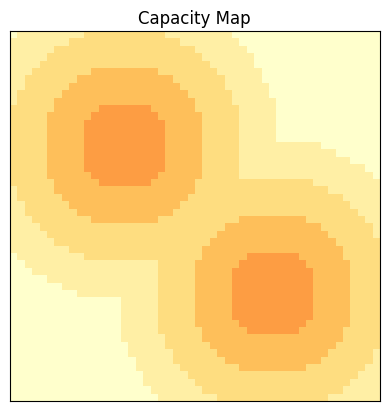

In [29]:
env = Sugarscape(50)
plot_2D_array(env.make_capacity(), cmap='YlOrRd', vmax=9, title='Capacity Map')

## **Agent Tendencies** 

- Agents move towards high-sugar areas, with those having high vision moving faster

- Agents born in low-sugar areas may starve unless they have a high initial sugar level and vision

- Agents with high metabolism or low vision are more likely to starve within high-sugar areas due to competition for sugar



We can closely observe some of the characteristics of the agents through each time step by using an animation. 

In [30]:
env = Sugarscape(n=50, num_agents=400)
a= Animation2D(env, frames=50, figsize=(6,6))
a.show()

## **Experiments** 

Agent count over time, wealth inequality, migration in waves.

### **Agent Count Over Time** 

We see that the amount of immortal agents levels off at a "carrying capacity" and the population of mortal agents begin to die off at 60 time steps (because lifespan is 60-100).

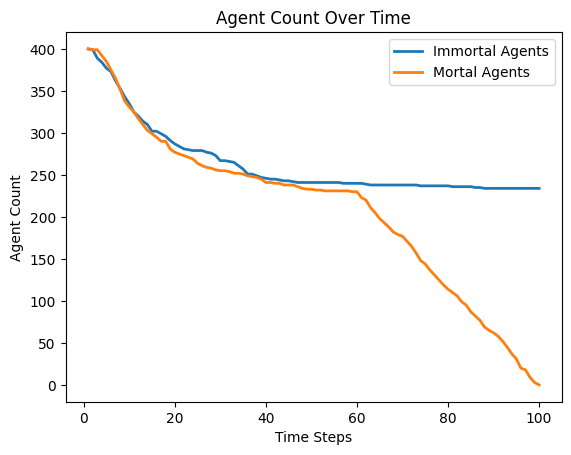

In [31]:
def agent_count(env, steps):
    """ Returns a list of the amount of agents over a given number of time steps """
    step_list = [step for step in range(1, steps+1)]
    agents = []
    for i in range(steps):
      env.step()
      agents.append(len(env.agents))
    carrying_capacity = len(env.agents)
    return [step_list, agents, carrying_capacity]

steps = 100
env = Sugarscape(50, num_agents=400)
m_env = Sugarscape(50, num_agents=400, mortal=True)

#get the agent data for both mortal and immortal agents

agent_data = agent_count(env, steps)
mortal_agent_data = agent_count(m_env, steps)

#label the plot

plt.title('Agent Count Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Agent Count')

#plot immortal agent data
plt.plot(agent_data[0], agent_data[1], label='Immortal Agents')

#plot mortal agent data
plt.plot(mortal_agent_data[0], mortal_agent_data[1], label='Mortal Agents')

#legend
plt.legend()

plt.show()

In [32]:
f'Carrying capacity of {agent_data[2]}'

'Carrying capacity of 234'

When we set the metabolism of the agents to a static 4 the population decreases further. We also see that it levels off at a lower carrying capacity.

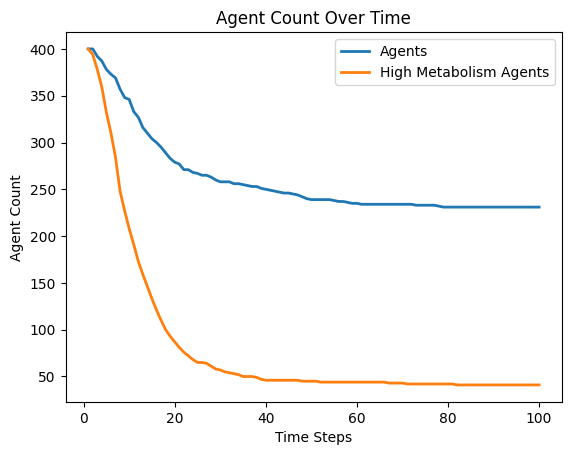

In [33]:
env = Sugarscape(50, num_agents=400)
m_env = Sugarscape(50, num_agents=400, high_met=True)

#get the agent data for both mortal and immortal agents

agent_data = agent_count(env, steps)
m_agent_data = agent_count(m_env, steps)

#label the plot

plt.title('Agent Count Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Agent Count')

#plot immortal agent data
plt.plot(agent_data[0], agent_data[1], label='Agents')

#plot mortal agent data
plt.plot(mortal_agent_data[0], m_agent_data[1], label='High Metabolism Agents')

#legend
plt.legend()

plt.show()

In [34]:
f'Carrying capacity of high metabolsim agents: {m_agent_data[2]}'

'Carrying capacity of high metabolsim agents: 41'

### **Wealth Inequality** 

- Sugarscape demonstrates wealth inequality with some agents accumulating sugar faster than others, but the distribution of wealth changes over time and does not reach a steady state.

- When agents have finite lifespans, the model produces a stationary distribution of wealth.

In this version of the model agents are given a random lifespan between 60 to 100 (by making mortal=True)

When an agent dies, it is replaced by a new agent with random attributes, keeping the number of agents constant.

In [35]:
env = Sugarscape(50, num_agents=400, mortal=True, replace_agents=True)
env.mortal

True

Cumulative Distribution Function (CDF) plot

 - runs the model for 500 steps, recording the distribution of wealth after each 100 steps


 Using this graph we can see the distribution of wealth. We see that most agents have little sugar while very few have a lot. 

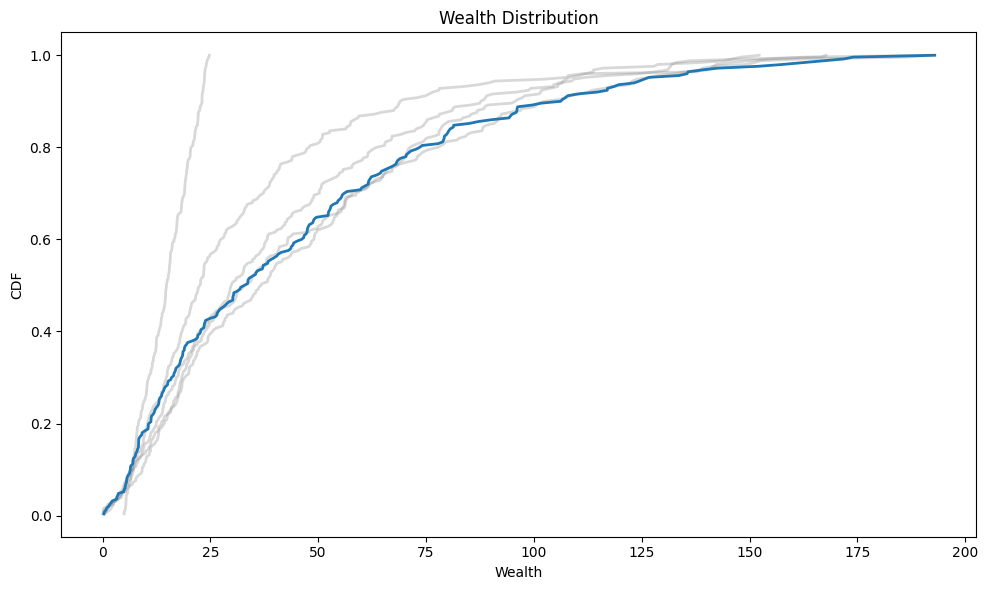

In [36]:
np.random.seed(17)

env = Sugarscape(50, num_agents=250, mortal=True, replace=True)

#create a cumulative distribution function (CDF) from the sugar levels of agents in the initial environment
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)

#create a list to store the CDFs over time
cdfs = [cdf]

#loop over 5 iterations of 100 time steps each in the environment
for i in range(5):
    env.loop(100)
    #update the CDF with sugar levels of agents after each iteration
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

plt.figure(figsize=(10, 6))

#function to plot CDFs
def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)

#plot the CDFs from the first iteration to the fourth iteration with color grey
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)

#plot the CDF from the last iteration with color blue
plot_cdfs(cdfs[-1:], color='C0')

decorate(title='Wealth Distribution', xlabel='Wealth', ylabel='CDF')

#plt.show('figs/chap10-4')

After 200 steps we see that the distribution doesn't change over time.

### **Migration in Waves**

- When all agents start in the upper-left corner, they move towards the closest high-capacity cells or "peaks" where the most sugar is

- If there are more agents than a single peak can support, the sugar quickly depletes and agents are forced to move to lower sugar areas
- In this model agents must have longer vision (**"farsighted**) so they are able to cross "valleys" between peaks and migrate towards the northeast in a wave like pattern
- As these agents move, they leave empty cells behind them, and other agents do not follow until the sugar grows back in those areas

In [37]:
np.random.seed(17)

env = Sugarscape(50, num_agents=200, starting_box=(20, 20), farsighted=True) # agent vision is 16
    
a= Animation2D(env, frames=20, figsize=(6,6))
a.show()

#### More on farsighted agents 

When the farsighted agents are not put in a starting box they also display some of the same interesting tendencies. 
- For example after the first time step, when too many agents occupy the high sugar region agents are blocked off and are forced to be in the lower sugar regions


In [38]:
np.random.seed(17)

env = Sugarscape(50, num_agents=400, farsighted=True) # agent vision is 16
    
a= Animation2D(env, frames=10, figsize=(6,6))
a.show()